## (C) EDA

In [2]:
import numpy as np 
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import seaborn as sns

# Set up visualization style
plt.style.use('ggplot')
sns.set_palette("husl")

# View all columns of a dataframe
pd.set_option('display.max_columns', None)

import os

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

## 01. GP Landscape Analysis

In [3]:
gp_practices = pd.read_csv('../data/gp_practices.csv')
gps = pd.read_csv('../data/gps.csv')

In [4]:
print(gp_practices.shape, gps.shape)

(1057, 5) (5482, 7)


In [5]:
# Remove duplicates 
gp_practices = gp_practices.drop_duplicates()

gps = gps.drop_duplicates()

print(gp_practices.shape, gps.shape)

(888, 5) (5482, 7)


In [6]:
gp_practices.to_csv('../data/gp_practices.csv', index=None)

The plan is to plot the values but on Scotland map. 

In [7]:
geo = gpd.read_file("../data/lad.json")

In [8]:
print(geo['LAD13NM'].to_list(), len(geo['LAD13NM']))

['Clackmannanshire', 'Dumfries and Galloway', 'East Ayrshire', 'East Lothian', 'East Renfrewshire', 'Eilean Siar', 'Falkirk', 'Fife', 'Highland', 'Inverclyde', 'Midlothian', 'Moray', 'North Ayrshire', 'Orkney Islands', 'Perth and Kinross', 'Scottish Borders', 'Shetland Islands', 'South Ayrshire', 'South Lanarkshire', 'Stirling', 'Aberdeen City', 'Aberdeenshire', 'Argyll and Bute', 'City of Edinburgh', 'Renfrewshire', 'West Dunbartonshire', 'West Lothian', 'Angus', 'Dundee City', 'North Lanarkshire', 'East Dunbartonshire', 'Glasgow City'] 32


In [9]:
print(set(gp_practices['Geography'].to_list()), len(set(gp_practices['Geography'])))

{'West Dunbartonshire', 'North Ayrshire', 'Stirling', 'Edinburgh', 'South Lanarkshire', 'Fife', 'Argyll and Bute', 'Dundee City', 'Western Isles', 'Aberdeenshire', 'East Renfrewshire', 'Glasgow City', 'North Lanarkshire', 'Highland', 'West Lothian', 'East Lothian', 'Perth and Kinross', 'South Ayrshire', 'Dumfries and Galloway', 'Falkirk', 'Orkney Islands', 'Renfrewshire', 'Midlothian', 'East Ayrshire', 'Scottish Borders', 'Clackmannanshire', 'Angus', 'Shetland Islands', 'Moray', 'Aberdeen City', 'Inverclyde', 'East Dunbartonshire'} 32


In [10]:
name_correction_mapping = geo_mapping_gp_practices = {
    "Edinburgh": "City of Edinburgh",
    "Western Isles": "Eilean Siar"
}

gp_practices["Geography"] = gp_practices["Geography"].replace(name_correction_mapping)

Now, the heatmap color scale on extremes is too dark to see any labels on map. So we lighten it a bit, without losing on the spread of colors across choropleth. 

In [11]:
def lighten_cmap(base_cmap_name="GnBu", min_lightness=0.2):
    base = plt.cm.get_cmap(base_cmap_name)
    colors = base(np.linspace(0, 1, 256))
    colors[: , :3] = colors[: , :3] * (1 - min_lightness) + min_lightness

    return mcolors.ListedColormap(colors)

In [12]:
def plot_choropleth(gp_practices_geo, value_col, title, cmap="GnBu", figsize=(15, 17), small_area_factor=0.5, small_font=7, large_font=10):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    gp_practices_geo.plot(
        column=value_col,
        cmap=cmap,
        linewidth=0.8,
        ax=ax,
        edgecolor="0.8",
        legend=True,
        legend_kwds={
            'orientation': 'horizontal',
            'shrink': 0.5,
            'pad': 0.02,
            'aspect': 30
        }
    )

    mean_area = gp_practices_geo.geometry.area.mean()
    for idx, row in gp_practices_geo.iterrows():
        point = row.geometry.representative_point()
        area = row.geometry.area
        font_size = small_font if area < mean_area * small_area_factor else large_font
        ax.annotate(
            text=str(row[value_col]),
            xy=(point.x, point.y),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=font_size,
            fontweight='bold',
            color="black"
        )

    ax.set_xlim(gp_practices_geo.total_bounds[0], gp_practices_geo.total_bounds[2])
    ax.set_ylim(gp_practices_geo.total_bounds[1], gp_practices_geo.total_bounds[3])

    ax.set_title(title, fontdict={'fontsize': 12})
    ax.axis("off")
    plt.show()

In [13]:
geo_stats = gp_practices.groupby('Geography').agg(
    total_gp_practices=('PracticeCode', 'count'),
    total_list_size=('PracticeListSize', 'sum')
).reset_index()

geo_stats['gp_practice_per_100000'] = round(geo_stats['total_gp_practices']*100000 / geo_stats['total_list_size'], 1)

In [14]:
os.makedirs('../results', exist_ok=True)

In [15]:
geo_stats.to_csv('../results/gp_practices_region.csv', index=None)

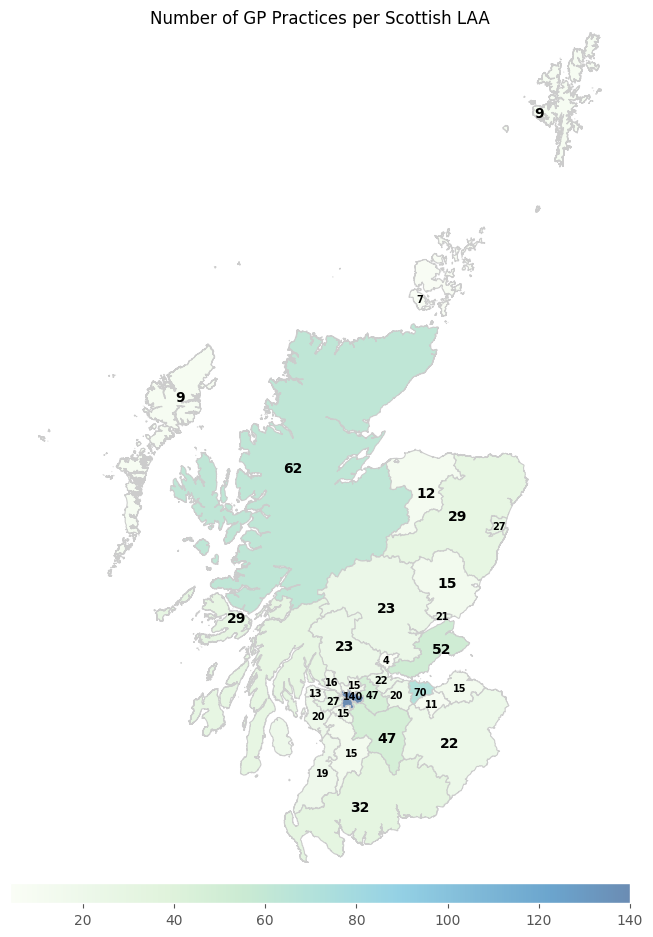

In [16]:
gp_practices_geo = geo.merge(geo_stats, left_on='LAD13NM', right_on='Geography', how='left')

light_gnbu = lighten_cmap("GnBu", min_lightness=0.4)

plot_choropleth(gp_practices_geo, value_col='total_gp_practices', cmap=light_gnbu, title=f"Number of GP Practices per Scottish LAA", figsize=(16, 13))

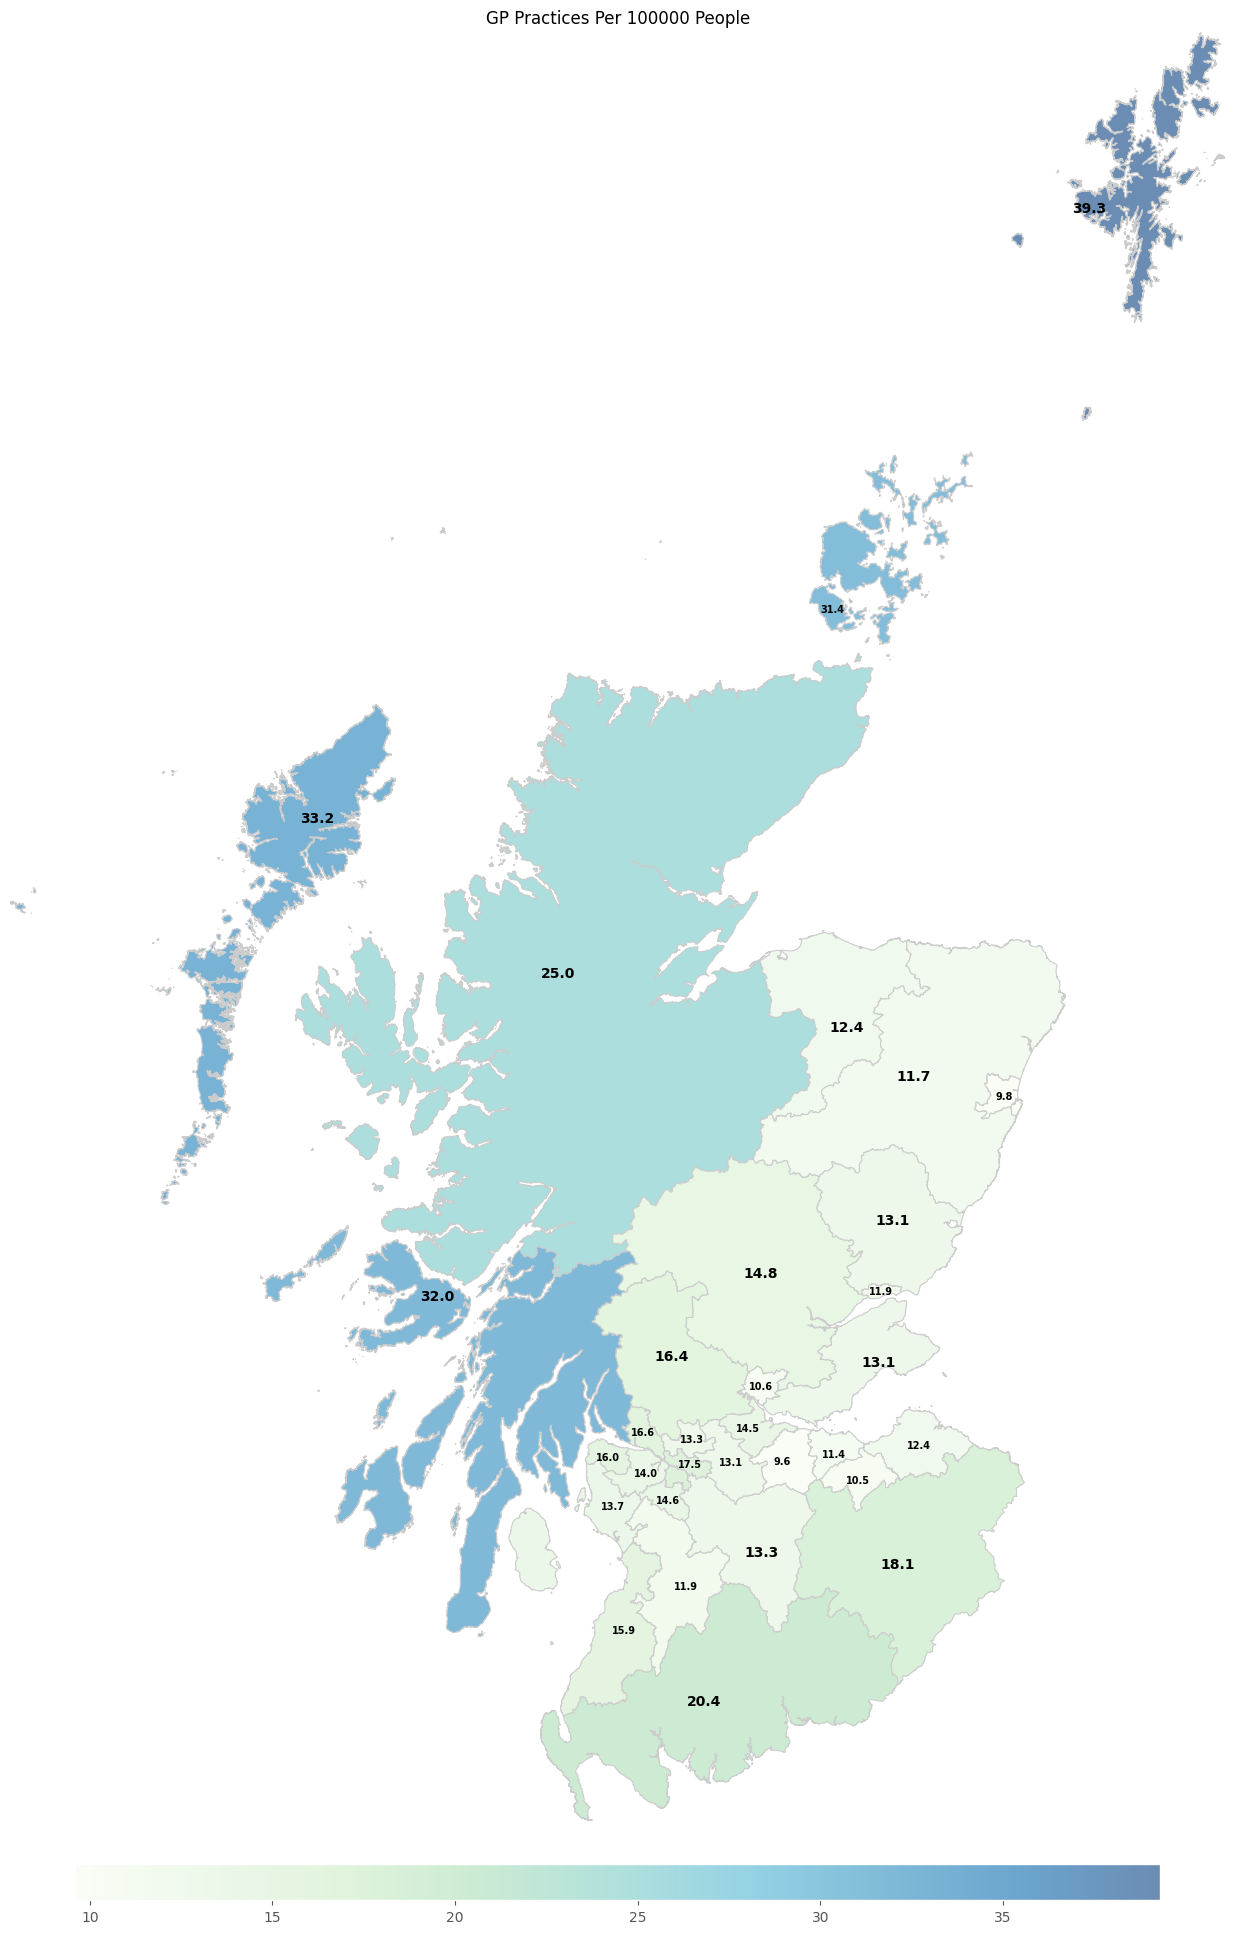

In [17]:
plot_choropleth(gp_practices_geo, value_col='gp_practice_per_100000', figsize=(28, 28), cmap=light_gnbu, 
                title="GP Practices Per 100000 People")

However, #GP_Practices and #Registered_List_Size/GP_Practices is not a good metric to calculate the underserved and overserved areas. What really matters is how many #GPs are there to cater these people. Let's find that!

In [18]:
gp_counts = gps.groupby('PracticeCode').size().reset_index(name='Staff')

In [19]:
gp_practices_with_staff = gp_practices.merge(gp_counts, on='PracticeCode', how='left')

In [20]:
geo_stats = gp_practices_with_staff.groupby('Geography').agg(
    total_staff=('Staff', 'sum'),
    total_list_size=('PracticeListSize', 'sum')
).reset_index()

geo_stats['staff_per_100000'] = round(geo_stats['total_staff']*100000 / geo_stats['total_list_size'], 1)

In [21]:
gp_practices_geo = geo.merge(geo_stats, left_on='LAD13NM', right_on='Geography', how='left')

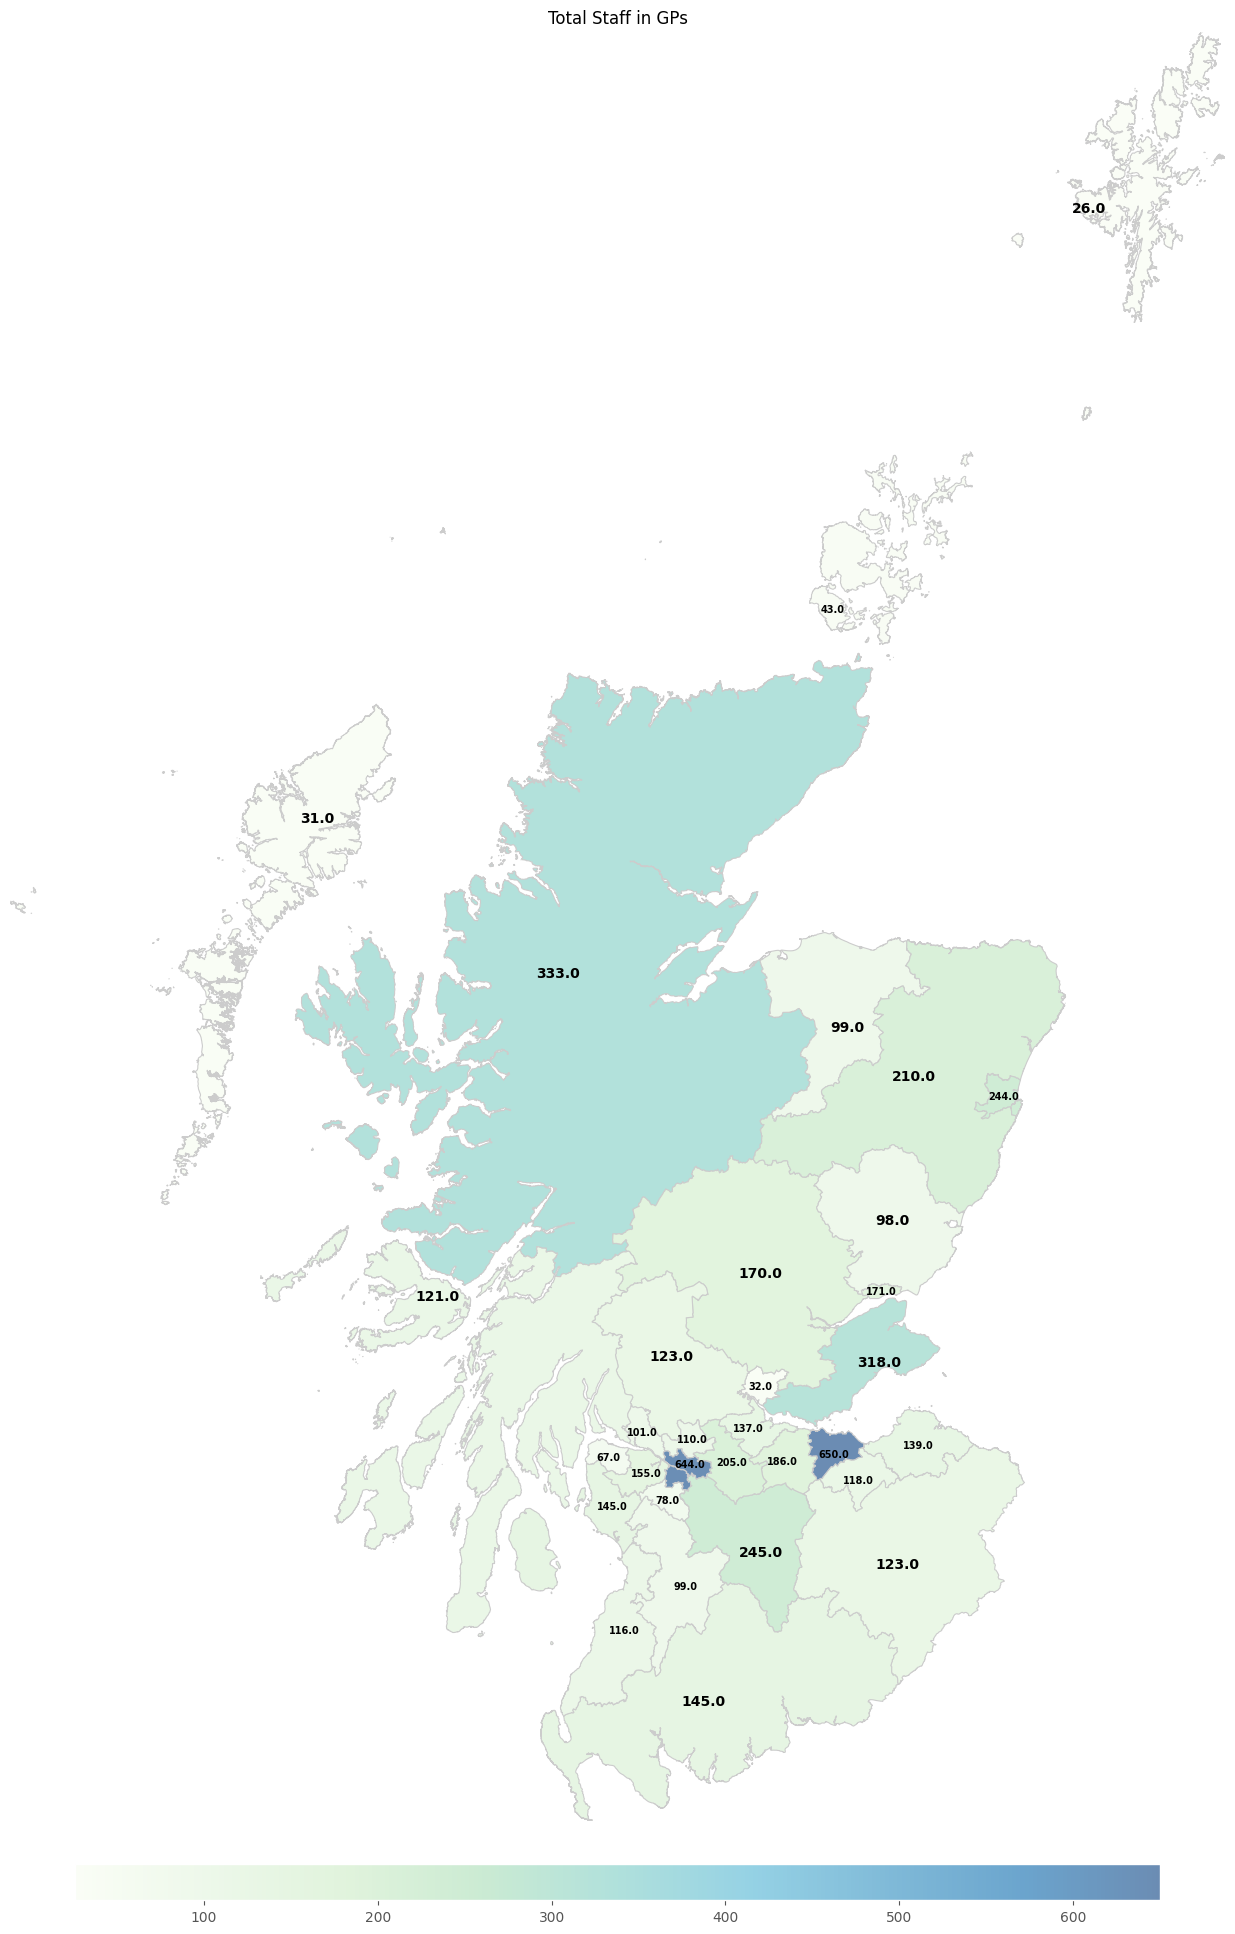

In [22]:
plot_choropleth(gp_practices_geo, value_col='total_staff', cmap=light_gnbu, title="Total Staff in GPs", figsize=(28, 28))

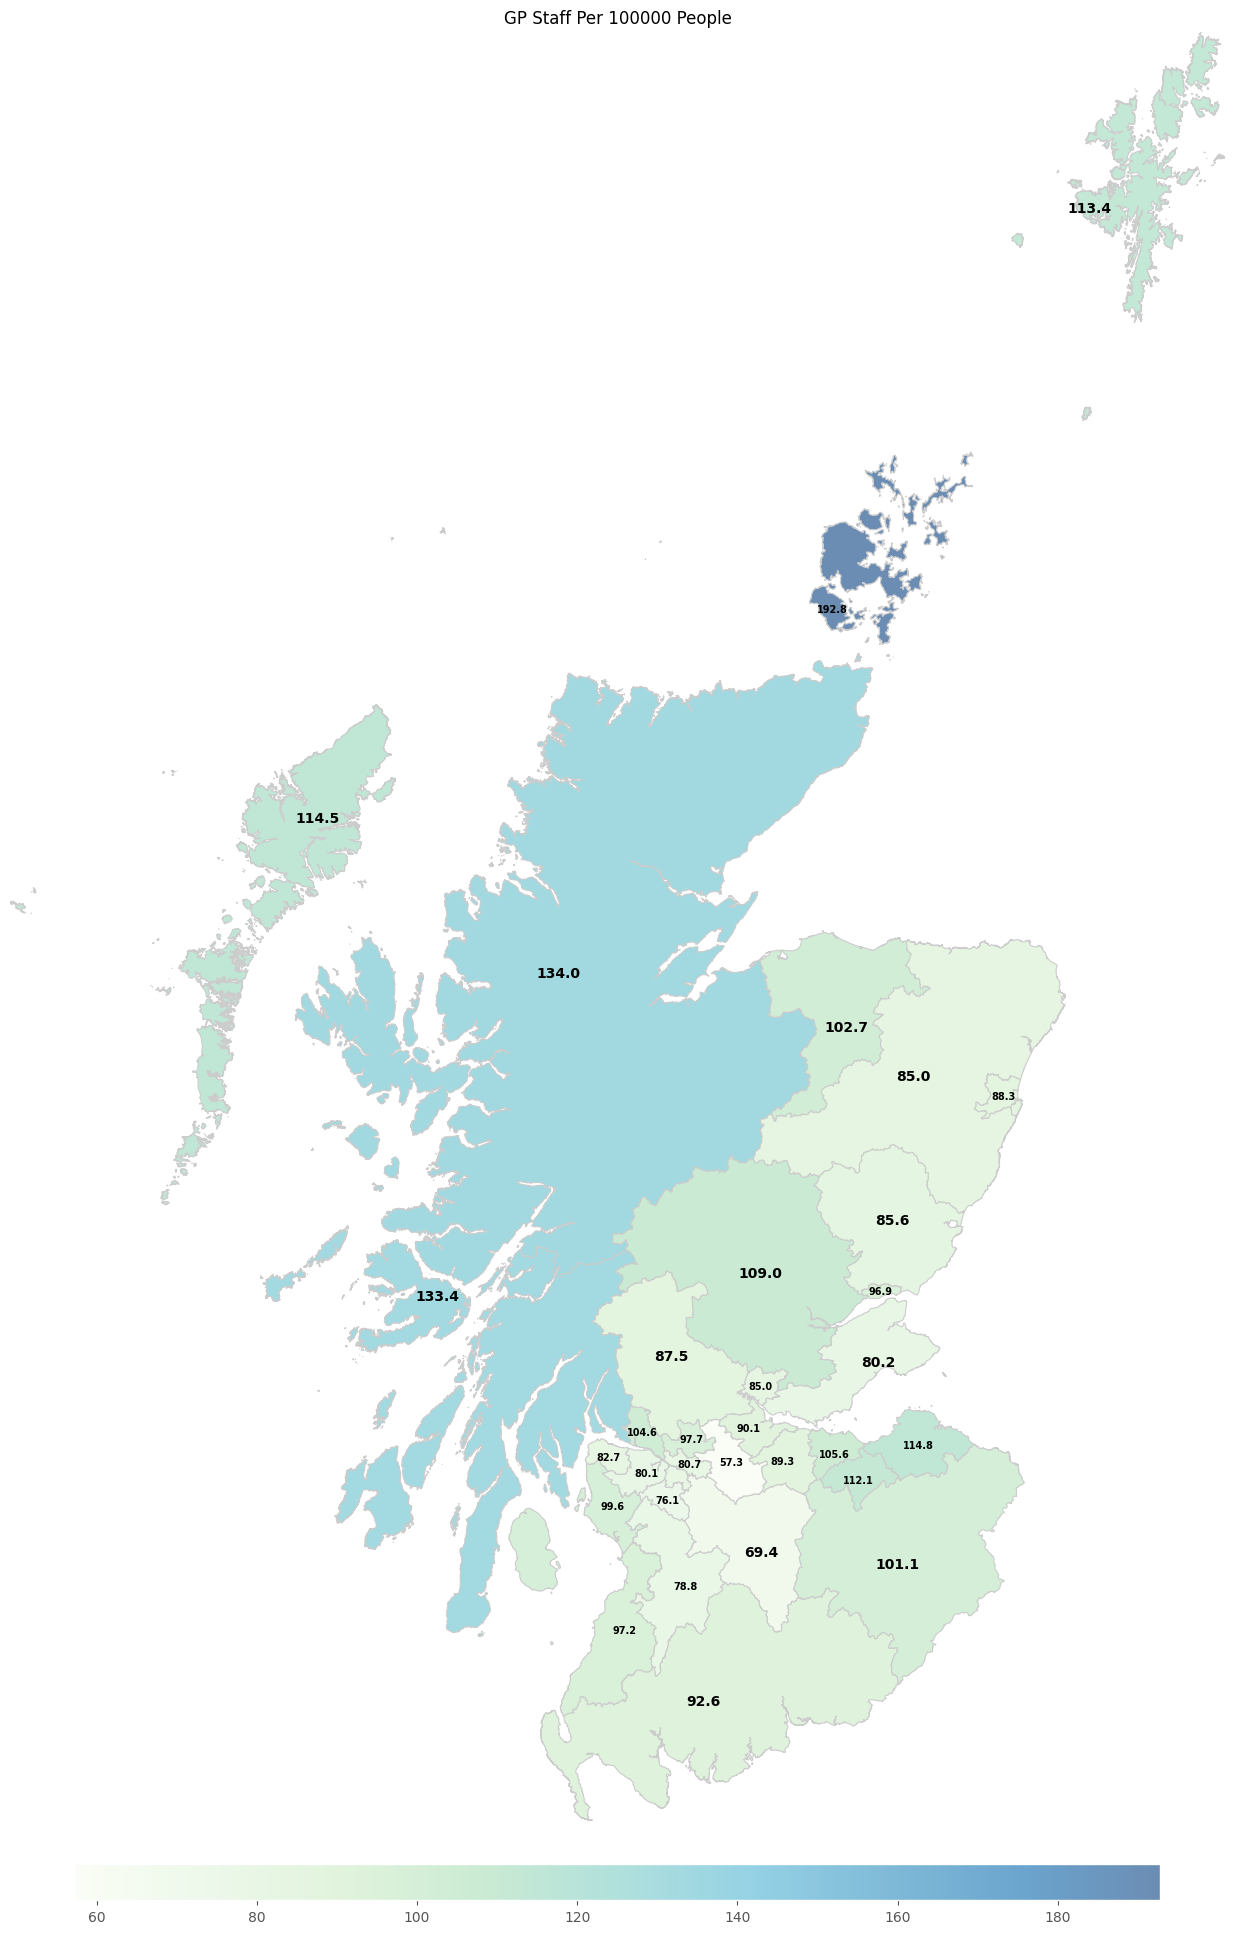

In [23]:
plot_choropleth(gp_practices_geo, value_col='staff_per_100000', cmap=light_gnbu, title="GP Staff Per 100000 People", figsize=(28, 28))

In [24]:
df = gp_practices_geo[['Geography', 'total_staff',	'total_list_size',	'staff_per_100000']]

In [25]:
df.to_csv('../results/gps_region.csv', index=None)

## 02. Patient Demographics Analysis

In [26]:
gp_list_sizes = pd.read_csv('../data/gp_list_sizes.csv')

gp_list_sizes = gp_list_sizes[gp_list_sizes['AgeGroup'] != 'AllAges']
gp_list_sizes.to_csv('../data/gp_list_sizes.csv', index=None)

gp_list_sizes.shape

(21312, 4)

In [27]:
patients_geo = gp_list_sizes.merge(
    gp_practices[['PracticeCode', 'Geography']],
    on='PracticeCode',
    how='left'
)

geo_totals = patients_geo.groupby('Geography')['Count'].sum().reset_index()

age_totals = patients_geo.groupby('AgeGroup')['Count'].sum().reset_index()

geo_age_totals = patients_geo.groupby(['Geography', 'AgeGroup'])['Count'].sum().reset_index()

In [28]:
geo_age_perc = geo_age_totals.copy()

geo_age_perc['Percent'] = (
    geo_age_perc['Count'] / geo_age_perc.groupby('Geography')['Count'].transform('sum') * 100
)

print(geo_age_perc.shape)

(256, 4)


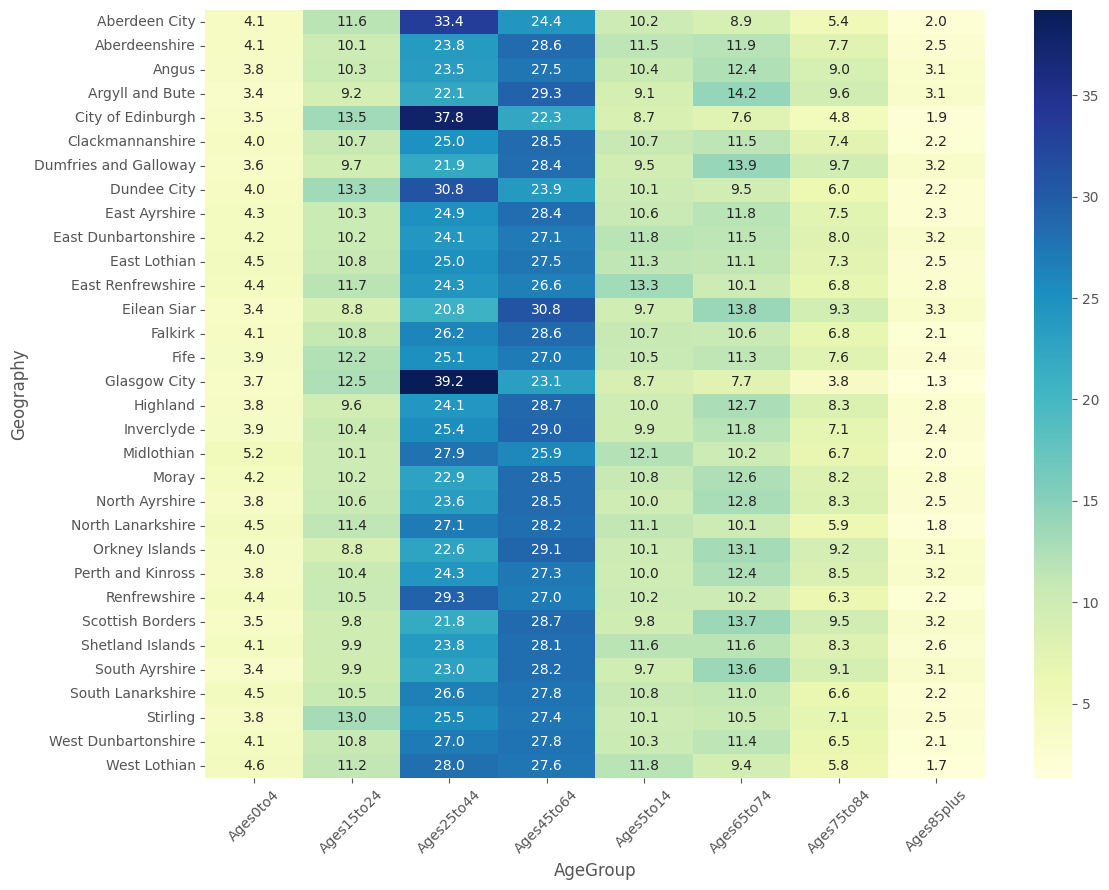

In [29]:
heatmap_data = geo_age_perc.pivot(index='Geography', columns='AgeGroup', values='Percent').fillna(0)

plt.figure(figsize=(12,9))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
geo_age_perc.to_csv("../results/patient_age_distribution_by_geography.csv", index=False)

### Adding Disease Prevalence

In [31]:
disease_prevalence = pd.read_csv('../data/disease_prevalence.csv')

disease_prevalence.shape

(1356999, 8)

In [32]:
disease_prevalence = disease_prevalence[disease_prevalence['Age'] != 'All']

disease_prevalence.shape

(1285578, 8)

In [33]:
disease_prevalence.to_csv('../data/disease_prevalence.csv', index=None)

In [34]:
merged_df = disease_prevalence.merge(
    gp_practices[['PracticeCode', 'Geography']],
    on='PracticeCode',
    how='left'
)

In [35]:
merged_df = merged_df[~merged_df['Geography'].isna()]

In [36]:
merged_df['PracticeCode'].nunique()

606

In [37]:
# Drop records with missing geography 
merged_df = merged_df.dropna(subset=['Geography'])

merged_df.shape

(1238382, 9)

In [38]:
merged_df['Year'] = pd.to_datetime(merged_df['Year'], format='%Y')

merged_df['Age_Group'] = merged_df['Age_Group'].str.strip()

In [39]:
prevalence_by_region_age = merged_df.groupby(
    ['Geography', 'Age_Group', 'Disease', merged_df['Year'].dt.year]
)['PatientCount'].sum().unstack().reset_index()

In [40]:
prevalence_by_region_age.sample(5)

Year,Geography,Age_Group,Disease,2018,2019,2020,2021,2022,2023
74,Aberdeen City,Ages45to64,Rheumatoid Arthritis,335,340,305,315,295,295
1115,East Dunbartonshire,Ages25to44,Mental Health,185,190,175,170,170,175
105,Aberdeen City,Ages65to74,Epilepsy,260,285,295,300,304,313
3292,Scottish Borders,Ages65to74,Coronary Heart Disease (CHD),1562,1538,1537,1562,1535,1446
19,Aberdeen City,Ages15to24,Asthma,1150,1060,1122,987,901,880


In [41]:
prevalence_by_region_age.to_csv('../results/prevalence_by_region_age_year.csv', index=False)

In [42]:
geo_age_perc.rename(columns={"AgeGroup": "Age_Group"}, inplace=True)

merged = prevalence_by_region_age.merge(
    geo_age_perc[["Geography", "Age_Group", "Count"]],
    on=["Geography", "Age_Group"],
    how="left"
)

year_cols = [2018,	2019,	2020,	2021,	2022,	2023]

for col in year_cols:
    merged[col] = round((merged[col] / merged["Count"]) * 100000, 1)

merged = merged.drop(columns=["Count"])

In [43]:
merged.to_csv('../results/prevalence_per_100000_by_region_age_year.csv', index=False)

In [44]:
os.makedirs('plots', exist_ok=True)
os.makedirs('csv_exports', exist_ok=True)

In [45]:
diseases = merged['Disease'].unique()

year_columns = year_cols
councils = merged['Geography'].unique()
age_groups = merged['Age_Group'].unique()

In [46]:
def create_summary_plot(disease):
    """Create summary plot with specific layout: box plot (top-left), trend (bottom-left), geography bar (right)"""
    disease_data = merged[merged['Disease'] == disease].copy()
    
    # Create figure with custom grid layout
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1])
    
    # Box plot (top-left)
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Overall trend (bottom-left) 
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Geography bar chart (right side, spanning full height)
    ax3 = fig.add_subplot(gs[:, 1])
    
    # 1. Box plot by age group (MUST HAVE as specified)
    age_group_data = []
    age_group_labels = []
    for age_group in sorted(disease_data['Age_Group'].unique()):
        age_data = disease_data[disease_data['Age_Group'] == age_group]
        all_values = age_data[year_columns].values.flatten()
        # Include all values including zeros for accurate distribution
        age_group_data.append(all_values)
        age_group_labels.append(age_group.replace('Ages', ''))  # Clean labels
    
    box_plot = ax1.boxplot(age_group_data, labels=age_group_labels, patch_artist=True)
    
    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(age_group_data)))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_title('Distribution by Age Group\n(All Regions & Years)', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Cases per 100,000', fontweight='bold')
    ax1.set_xlabel('Age Group', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    
    # 2. Overall trend across years (average across all councils and age groups)
    yearly_means = disease_data[year_columns].mean()
    
    ax2.plot(year_columns, yearly_means, 
             marker='o', linewidth=3, markersize=8, 
             color='darkblue')
    
    ax2.set_title('Overall Trend Across Years\n(Average Prevalence)', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Cases per 100,000', fontweight='bold')
    ax2.set_xlabel('Year', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45, labelsize=10)
    
    # Add trend line
    x_numeric = np.arange(len(year_columns))
    z = np.polyfit(x_numeric, yearly_means, 1)
    p = np.poly1d(z)
    ax2.plot(year_columns, p(x_numeric), "--", alpha=0.8, color='red', linewidth=2)
    
    # 3. Average cases across ALL geographies (highest to lowest)
    # Calculate average across all years and age groups for each geography
    geography_avg = disease_data.groupby('Geography')[year_columns].mean().mean(axis=1).sort_values(ascending=True)
    
    # Create horizontal bar chart
    y_pos = np.arange(len(geography_avg))
    bars = ax3.barh(y_pos, geography_avg.values, color=plt.cm.viridis(np.linspace(0, 1, len(geography_avg))))
    
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(geography_avg.index, fontsize=9)
    ax3.set_xlabel('Average Cases per 100,000\n(All Years & Age Groups)', fontweight='bold')
    ax3.set_title('Geography Overview\n(Lowest to Highest)', fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, geography_avg.values)):
        if value > 0:  # Only show labels for non-zero values
            ax3.text(value + max(geography_avg.values) * 0.01, i, f'{value:.1f}', 
                    va='center', fontsize=8, alpha=0.8)
    
    # Main title
    plt.suptitle(f'{disease}', fontsize=16, fontweight='bold', y=0.95)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    # Save
    clean_name = "".join(c for c in disease if c.isalnum() or c in (' ', '-', '_')).replace(' ', '_')
    plt.savefig(f'plots/{clean_name}_summary.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()

In [47]:
def create_csv_exports():
    """Create comprehensive CSV files for further EDA"""
    
    print("Creating CSV exports for EDA...")
    
    # 1. Age Group Analysis
    age_group_analysis = []
    for age_group in age_groups:
        age_data = merged[merged['Age_Group'] == age_group]
        
        for disease in diseases:
            disease_age_data = age_data[age_data['Disease'] == disease]
            if len(disease_age_data) > 0:
                analysis = {
                    'Age_Group': age_group,
                    'Disease': disease,
                    'Mean_Prevalence': disease_age_data[year_columns].values.mean(),
                    'Max_Prevalence': disease_age_data[year_columns].values.max(),
                    'High_Prevalence_Councils': len(disease_age_data[disease_age_data[year_columns].max(axis=1) > disease_age_data[year_columns].values.mean() + disease_age_data[year_columns].values.std()])
                }
                age_group_analysis.append(analysis)
    
    age_analysis_df = pd.DataFrame(age_group_analysis)
    age_analysis_df.to_csv('csv_exports/age_group_disease_analysis.csv', index=False)
    
    # 2. Geography Rankings
    geography_rankings = []
    for council in councils:
        council_data = merged[merged['Geography'] == council]
        
        council_stats = {
            'Geography': council,
            'Total_Disease_Types': council_data['Disease'].nunique(),
            'Overall_Avg_Prevalence': council_data[year_columns].values.mean(),
            'Highest_Disease_Prevalence': council_data[year_columns].values.max(),
            'Most_Affected_Disease': council_data.loc[council_data[year_columns].max(axis=1).idxmax(), 'Disease'],
        }
        
        # Disease-specific rankings for this council
        for disease in diseases:
            disease_council_data = council_data[council_data['Disease'] == disease]
            if len(disease_council_data) > 0:
                council_stats[f'{disease}_Avg'] = disease_council_data[year_columns].values.mean()
        
        geography_rankings.append(council_stats)
    
    geography_df = pd.DataFrame(geography_rankings)
    geography_df.to_csv('csv_exports/geography_rankings.csv', index=False)
    
    # 3. High-Risk Combinations (Top prevalence combinations)
    high_risk = merged.copy()
    high_risk['Average_Prevalence'] = high_risk[year_columns].mean(axis=1)
    high_risk['Max_Prevalence'] = high_risk[year_columns].max(axis=1)
    
    # Get highest risk combinations
    top_risk = high_risk[['Geography', 'Age_Group', 'Disease', 'Average_Prevalence', 'Max_Prevalence'] + year_columns]
    top_risk.to_csv('csv_exports/high_risk_combinations.csv', index=False)
    
    # 4. Disease Correlation Matrix (how diseases correlate across regions/age groups)
    # Create a simplified approach for correlation analysis
    disease_correlation_data = []
    
    for _, row in merged.iterrows():
        # Average prevalence across all years for this combination
        avg_prevalence = row[year_columns].mean()
        disease_correlation_data.append({
            'Geography': row['Geography'],
            'Age_Group': row['Age_Group'],
            'Disease': row['Disease'],
            'Average_Prevalence': avg_prevalence
        })
    
    # Convert to DataFrame and pivot
    corr_df = pd.DataFrame(disease_correlation_data)
    pivot_for_corr = corr_df.pivot_table(
        index=['Geography', 'Age_Group'],
        columns='Disease',
        values='Average_Prevalence',
        fill_value=0
    )
    
    # Calculate correlation matrix
    correlation_matrix = pivot_for_corr.corr()
    correlation_matrix.to_csv('csv_exports/disease_correlation_matrix.csv')
    
    print("✅ CSV exports completed!")
    return  age_analysis_df, geography_df, top_risk, correlation_matrix

In [48]:
# Create CSV exports first
csv_results = create_csv_exports()

# Create summary visualizations for each disease
for i, disease in enumerate(diseases):
    print(f"Processing {disease} ({i+1}/{len(diseases)})...")
    
    try:
        create_summary_plot(disease)
        print(f"  ✓ Created summary visualization for {disease}")
    except Exception as e:
        print(f"  ✗ Error with {disease}: {str(e)}")

Creating CSV exports for EDA...
✅ CSV exports completed!
Processing Asthma (1/19)...
  ✓ Created summary visualization for Asthma
Processing Atrial Fibrillation (2/19)...
  ✓ Created summary visualization for Atrial Fibrillation
Processing Cancer (3/19)...
  ✓ Created summary visualization for Cancer
Processing Chronic Kidney Disease (CKD) (4/19)...
  ✓ Created summary visualization for Chronic Kidney Disease (CKD)
Processing Chronic Obstructive Pulmonary Disease (COPD) (5/19)...
  ✓ Created summary visualization for Chronic Obstructive Pulmonary Disease (COPD)
Processing Coronary Heart Disease (CHD) (6/19)...
  ✓ Created summary visualization for Coronary Heart Disease (CHD)
Processing Dementia (7/19)...
  ✓ Created summary visualization for Dementia
Processing Depression (8/19)...
  ✓ Created summary visualization for Depression
Processing Diabetes (9/19)...
  ✓ Created summary visualization for Diabetes
Processing Eating Disorder (10/19)...
  ✓ Created summary visualization for Eati

In [49]:
disease_corr = pd.read_csv('csv_exports/disease_correlation_matrix.csv')

disease_corr.set_index('Disease', inplace=True)

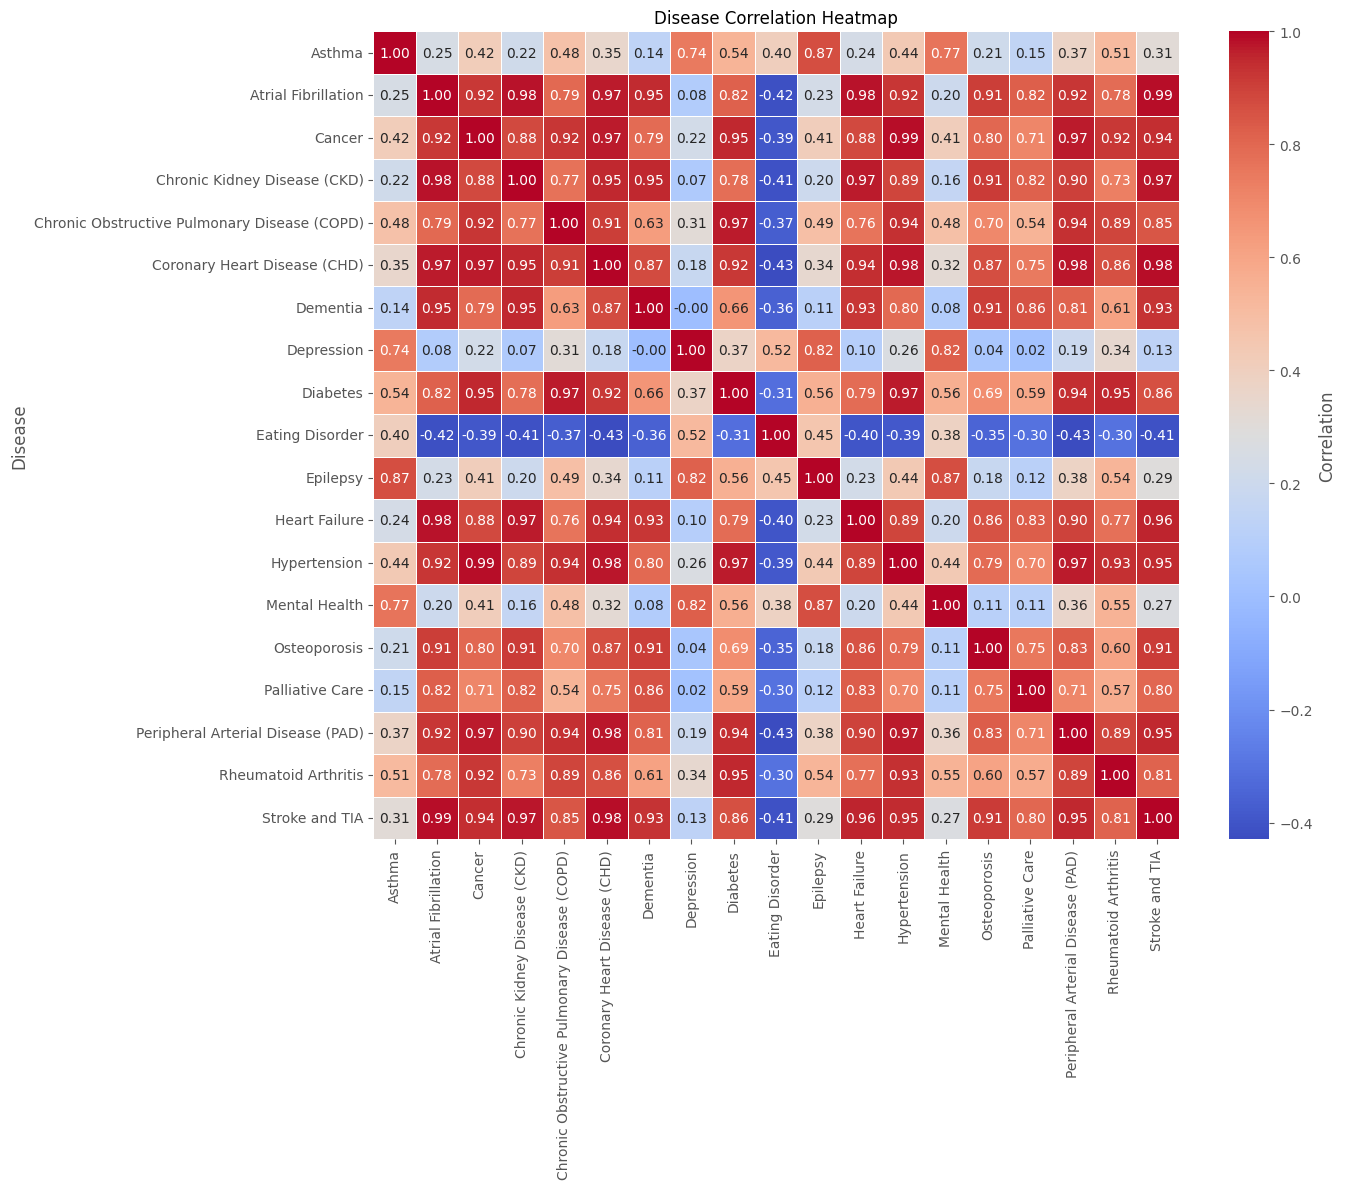

In [50]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    disease_corr, 
    annot=True,       # Show numbers on cells
    fmt=".2f",        # Format to 2 decimal places
    cmap="coolwarm",  # Or any colormap you like
    linewidths=0.5,
    cbar_kws={"label": "Correlation"}
)
plt.title("Disease Correlation Heatmap", fontsize=12)
plt.tight_layout()
plt.show()

<hr />